In [1]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.ndimage import gaussian_filter
import torch
import kornia
%matplotlib inline

In [2]:
FilPath = "/home/vipsl416-4-zhanglize/Datasets/IXI/IXI_HR/PD/train_slice_video_norm/000/*"
Files = sorted(glob(FilPath))

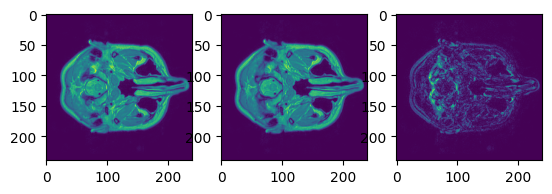

In [3]:
file1= np.load(Files[0])[:,:,0]
plt.subplot(1,3,1)
plt.imshow(file1)
plt.subplot(1,3,2)
file2= np.load(Files[1])[:,:,0]
plt.imshow(file2)
plt.subplot(1,3,3)
file_sub = abs(file1-file2)
plt.imshow(file_sub)
plt.show()

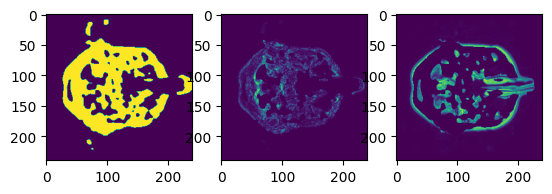

In [4]:
file1_mask= (gaussian_filter(np.load(Files[1])[:,:,0],sigma=3)-gaussian_filter(np.load(Files[2])[:,:,0],sigma=3))
# file1_mask= abs(np.load(Files[0])[:,:,0]-np.load(Files[1])[:,:,0])
file1_mask = file1_mask>file1_mask.mean()
plt.subplot(1,3,1)
plt.imshow(file1_mask)
file1_mask_file1 = file1_mask*file_sub
plt.subplot(1,3,2)
plt.imshow(file1_mask_file1)
file1_unmask_file1 =(1- file1_mask)*file1
plt.subplot(1,3,3)
plt.imshow(file1_unmask_file1)
plt.show()

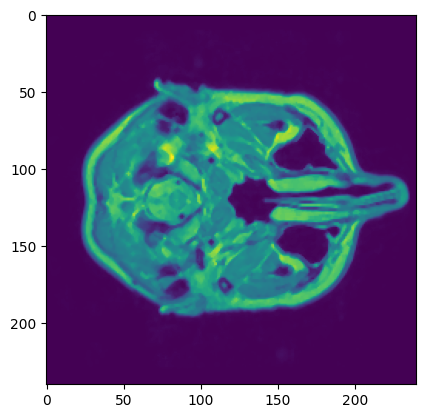

In [5]:
file1_med=signal.medfilt2d(file1/file1.max(), kernel_size=3)
plt.figure()
plt.imshow(file1_med)
plt.show()

In [6]:
signal.medfilt(file1/file1.max(), kernel_size=1).max()

1.0

## 生成mask

In [7]:
lqs = torch.rand(1,31,1,180,180)# 输入

In [8]:
b,t,c,h,w = lqs.shape
lqs_1 = lqs[:,:-1,:,:,:].reshape(-1, c, h, w)
lqs_2 = lqs[:,1:,:,:,:].reshape(-1, c, h, w)

lqs_gaussian = kornia.filters.gaussian_blur2d(lqs.view(-1,c,h,w) ,(3, 3),(1.5,1.5))

In [9]:
lqs1_guassian = lqs_gaussian[:-1,:,:,:]
lqs2_guassian = lqs_gaussian[1:,:,:,:]
Sub=[]
for i in range(t-1):
    Sub.append(abs(lqs1_guassian-lqs2_guassian))
mask = [i>i.mean() for i in Sub]

# method1

In [10]:
feats={"spatial":[None],
       "backward_1":[]}
def propagate(self, feats, module_name,mask):
    t = len(feats['spatial'])
    n, _, h, w = feats['spatial'][0].size()
    frame_idx = range(0, t)
    mapping_idx = list(range(0, len(feats['spatial'])))
    mapping_idx += mapping_idx[::-1]
    if 'backward' in module_name:
        frame_idx = frame_idx[::-1]
    feats_prop = feats['spatial'][0].new_zeros(n, self.mid_channels, h, w)
    for i,idx in enumerate(frame_idx):
        feat_current = feats['spatial'][mapping_idx[idx]]
        if i> 0 :
            feat_n2 = torch.zeros_like(feat_prop)# 创建t-2处全0矩阵
            if i>1:
                feat_n2 = feats[module_name][-2] #赋值t-2处
            feat_prop = self.propagate1(feat_prop, feat_n2)# 融合 t-1,t-2
        # feat = [feat_current] + [feats[k][idx] for k in feats if k not in ['spatial', module_name]] + [feat_prop]
        # 暂时去掉
        feat = self.propagate1(feat,feat_prop,feat_n2)
        feat_prop = feat_n2
        
        
        

In [13]:
def propagate2(feats, module_name):
    t = len(feats['spatial'])
    n, _, h, w = feats['spatial'][0].size()
    frame_idx = range(0, t)
    mapping_idx = list(range(0, len(feats['spatial'])))
    mapping_idx += mapping_idx[::-1]
    if 'backward' in module_name:
        frame_idx = frame_idx[::-1]
    feat_prop = feats['spatial'][0].new_zeros(n, 1, h, w)
    feat_prop_flag = -1
    flag=[]
    for i,idx in enumerate(frame_idx):
        print("{}第{}次".format(module_name,i))
        print("当前处理第{}帧".format(idx))
        feat_current = feats['spatial'][mapping_idx[idx]]
        if i> 0 :
            feat_n2 = torch.zeros_like(feat_prop)# 创建t-2处全0矩阵
            if i>1:
                feat_n2 = feats[module_name][-2] #赋值t-2处
                n2_flag = flag[-2]
                print("flag_n2第{}帧".format(n2_flag))
            # feat_prop = self.propagate1(feat_prop, feat_n2)# 融合 t-1,t-2
            #print("feat_prop:融合{}第{}帧".format(module_name,idx-2))
        # feat = [feat_current] + [feats[k][idx] for k in feats if k not in ['spatial', module_name]] + [feat_prop]
        # 暂时去掉
        # feat = self.propagate1(feat,feat_prop,feat_n2)
        feats[module_name].append(feat_prop)
        flag.append(idx)
        if feat_prop_flag>=0:
            print("feat_prop第{}帧".format(feat_prop_flag))
        #print("feat:融合{} 第{}帧".format(module_name,idx-2))
        #feat_prop = feat_n2
        if i>1:
            feat_prop_flag = n2_flag

In [14]:
featstest={}
featstest['spatial']=[torch.rand(1,1,64,64) for _ in range(0,7)]
featstest['backward_1']=[]
propagate2(featstest, 'backward_1')

backward_1第0次
当前处理第6帧
backward_1第1次
当前处理第5帧
backward_1第2次
当前处理第4帧
flag_n2第6帧
backward_1第3次
当前处理第3帧
flag_n2第5帧
feat_prop第3帧
backward_1第4次
当前处理第2帧
flag_n2第4帧
feat_prop第2帧
backward_1第5次
当前处理第1帧
flag_n2第3帧
feat_prop第1帧
backward_1第6次
当前处理第0帧
flag_n2第2帧
feat_prop第0帧


# method 2

In [ ]:
feats={"spatial_LV":[None],
      "spatial_HV":[None]}